<a href="https://colab.research.google.com/github/epodkwan/growthfunction/blob/main/bsplinetrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 202 kB 5.1 MB/s 
     |████████████████████████████████| 7.5 MB 40.7 MB/s 
     |████████████████████████████████| 217 kB 54.0 MB/s 
     |████████████████████████████████| 145 kB 61.5 MB/s 
     |████████████████████████████████| 596 kB 64.5 MB/s 
     |████████████████████████████████| 51 kB 1.7 MB/s 
     |████████████████████████████████| 76 kB 6.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from typing import Sequence
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit,random,vmap
from flax import linen as nn
from flax.training import train_state,checkpoints
import matplotlib.pyplot as plt

In [3]:
class SimpleMLP(nn.Module):
    features:Sequence[int]
    nodes:int

    @nn.compact
    def __call__(self,inputs):
        x=inputs
        for i,feat in enumerate(self.features):
            x=nn.Dense(feat)(x)
            x=jnp.sin(x)
        t=nn.Dense(nodes-1)(x)
        c=nn.Dense(nodes+1)(x)
        t=jnp.concatenate([jnp.zeros((t.shape[0],4)),jnp.cumsum(jax.nn.softmax(t),axis=1),jnp.ones((t.shape[0],3))],axis=1)
        c=jnp.concatenate([jnp.zeros((c.shape[0],1)),c],axis=1)
        return t,c

In [4]:
def npy_loader(path):
    return jnp.load(path)

In [5]:
@jit
def _deBoorVectorized(x,t,c):
    p=3
    k=jnp.digitize(x,t)-1
    d=[c[j+k-p] for j in range(0,p+1)]
    for r in range(1,p+1):
        for j in range(p,r-1,-1):
            alpha=(x-t[j+k-p])/(t[j+1+k-r]-t[j+k-p])
            d[j]=(1.0-alpha)*d[j-1]+alpha*d[j]
    return d[p]

In [6]:
layer_sizes=[64,64]
nodes=16
learning_rate=1e-6
epochs=200000
model=SimpleMLP(features=layer_sizes,nodes=nodes)
temp=jnp.array([[1]])
params=model.init(random.PRNGKey(0),temp)
tx=optax.adam(learning_rate=learning_rate)
opt_state=tx.init(params)
deBoor=vmap(_deBoorVectorized,in_axes=(None,0,0))

In [7]:
@jit
def eval_func(params,x,a):
    t,c=model.apply(params,x)
    preds=deBoor(jnp.clip(a,0,0.99999),t,c)
    return preds

In [8]:
@jit
def mse_loss(params,x,y_ref,a):
    preds=eval_func(params,x,a)
    diff=preds-y_ref
    return jnp.mean(diff*diff)

In [9]:
@jit
def train_step(params,opt_state,x,y_ref,a):
    loss,grads=jax.value_and_grad(mse_loss,argnums=0)(params,x,y_ref,a)
    updates,opt_state=tx.update(grads,opt_state)
    params=optax.apply_updates(params,updates)
    return loss,params,opt_state

In [10]:
@jit
def epoch_step(x_train,y_train,params,opt_state,order,a):
    order=random.permutation(random.PRNGKey(i),order)
    train_loss=0
    for j in range(25):
        x_batch=x_train[order[32*j:32*(j+1)],:]
        y_batch=y_train[order[32*j:32*(j+1)],:]
        loss,params,opt_state=train_step(params,opt_state,x_batch,y_batch,a)
        train_loss=train_loss+loss
    return train_loss,params

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
input_data=npy_loader("/content/drive/My Drive/Colab Notebooks/data1/cosmo.npy")
input_result=npy_loader("/content/drive/My Drive/Colab Notebooks/data1/combined.npy")
a=npy_loader("/content/drive/My Drive/Colab Notebooks/data1/999.npy")[0,:]
# input_result=jnp.log(raw_input_result)
x_train=input_data[0:800].reshape(800,-1)
y_train=input_result[0:800,:]
x_validate=input_data[800:900,0].reshape(100,-1)
y_validate=input_result[800:900,:]

1000 0.003437503
2000 0.00031985788
3000 6.429525e-05
4000 1.9827936e-05
5000 5.3153685e-06
6000 1.800113e-06
7000 7.768817e-07
8000 4.846007e-07
9000 3.5575525e-07
10000 2.837342e-07
11000 2.2734699e-07
12000 1.7771718e-07
13000 1.399467e-07
14000 1.12797146e-07
15000 9.4380475e-08
16000 8.2693184e-08
17000 7.49277e-08
18000 6.885361e-08
19000 6.3590115e-08
20000 5.8891768e-08
21000 5.4407867e-08
22000 5.0345577e-08
23000 4.6490026e-08
24000 4.284882e-08
25000 3.9492605e-08
26000 3.640432e-08
27000 3.357575e-08
28000 3.102931e-08
29000 2.8645747e-08
30000 2.6501118e-08
31000 2.4669324e-08
32000 2.3145075e-08
33000 2.1735984e-08
34000 2.0432076e-08
35000 1.9247286e-08
36000 1.8093735e-08
37000 1.707489e-08
38000 1.6165101e-08
39000 1.5313836e-08
40000 1.4593407e-08
41000 1.39011025e-08
42000 1.3337033e-08
43000 1.2844691e-08
44000 1.23888295e-08
45000 1.18973364e-08
46000 1.1432391e-08
47000 1.0986282e-08
48000 1.0516804e-08
49000 1.0062746e-08
50000 9.639464e-09
51000 9.222181e-09
520

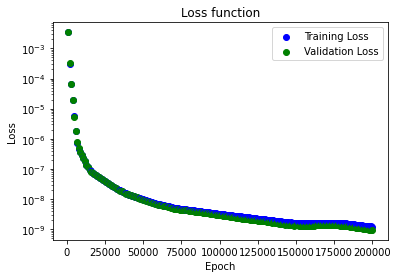

In [13]:
order=jnp.arange(800)
for i in range(epochs):
    train_loss,params=epoch_step(x_train,y_train,params,opt_state,order,a)
    if i % 1000 == 999:
        train_loss=train_loss/25
        validate_loss=mse_loss(params,x_validate,y_validate,a)
        print((i+1),validate_loss)
        plt.scatter((i+1),train_loss,c='b')
        plt.scatter((i+1),validate_loss,c='g')
print("Training ended")
state=train_state.TrainState.create(apply_fn=model.apply,params=params,tx=tx)
checkpoints.save_checkpoint(ckpt_dir="/content/drive/My Drive/Colab Notebooks",target=state,step=0,overwrite=True)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function")
plt.legend(["Training Loss","Validation Loss"])
plt.savefig("/content/drive/My Drive/Colab Notebooks/loss.png")

[[1.14873954e-04 1.19098928e-04 1.23479302e-04 ... 9.50610518e-01
  9.75030243e-01 9.99910474e-01]
 [1.32823639e-04 1.37708819e-04 1.42773642e-04 ... 9.64904308e-01
  9.82851267e-01 9.99995232e-01]
 [1.22703234e-04 1.27216175e-04 1.31895082e-04 ... 9.58123326e-01
  9.78963614e-01 9.99981463e-01]
 ...
 [1.23722581e-04 1.28273023e-04 1.32990797e-04 ... 9.58887935e-01
  9.79388237e-01 9.99960363e-01]
 [1.16822295e-04 1.21118952e-04 1.25573657e-04 ... 9.53041077e-01
  9.76781189e-01 1.00007653e+00]
 [1.67978622e-04 1.74156725e-04 1.80562085e-04 ... 9.78901148e-01
  9.89713073e-01 9.99615371e-01]]


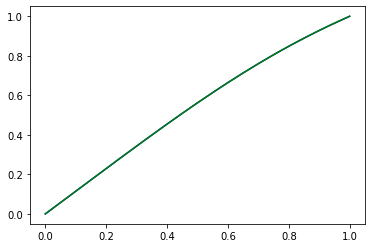

Max error = 0.19356012 %


In [14]:
x_test=input_data[900:1000,0].reshape(100,-1)
y_test=input_result[900:1000,:]
y_pred=eval_func(params,x_test,a)
print(y_pred)
plt.plot(a,y_pred[0,:],c='b')
plt.plot(a,y_test[0,:],c='g')
plt.show()
error=abs(y_pred/y_test-1)
print("Max error =",jnp.max(error)*100,"%")